In [112]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import pearsonr



# LN model

In [113]:
sta = np.load('sta_train_data.npy')
train_stim= np.load('train_stim.npy')
train_spikes = np.load('train_spikes.npy',allow_pickle=True)
test_stim = np.load('test_stim.npy')
test_spikes = np.load('test_spikes.npy',allow_pickle=True)
# time_points = np.arange(0, 31, 1/60)
# plt.plot(test_stim[5])


In [114]:
#This will be part of metadata but for now let's hard code it
frame_rate = 60  # Hz
frame_duration = 1 / frame_rate  # seconds per frame. Equivalent to bin size
total_duration = 31
def binarize_spike_trains(spikes_array, total_duration, bin_size=1/60):
    """
    Binarize spike trains based on a given bin size, allowing for multiple spikes per bin.
    
    Args:
        spikes_array (list of np.ndarray): List where each element is an array of spike times for a trial.
        total_duration (float): Total duration of each trial in seconds.
        bin_size (float): Duration of each bin in seconds. Default is 1/60 (assuming 60 Hz frame rate).
    
    Returns:
        np.ndarray: A binned spike count array with shape (num_trials, num_bins).
    """
    # Calculate the number of bins based on total duration and bin size
    num_bins = int(np.ceil(total_duration / bin_size))
    
    # Initialize the spike count array
    spike_count_trains = np.zeros((len(spikes_array), num_bins), dtype=int)
    
    for i, spike_times in enumerate(spikes_array):
        # Convert spike times to corresponding bin indices
        bin_indices = (spike_times / bin_size).astype(int)
        bin_indices = bin_indices[bin_indices < num_bins]  # Ensure indices are within bounds
        
        # Count spikes per bin by incrementing for each spike occurrence
        for bin_idx in bin_indices:
            spike_count_trains[i, bin_idx] += 1  # Increment count instead of setting to 1
    
    return spike_count_trains

# Example usage
desired_bin_size = 20/1000
train_binarized_spikes = binarize_spike_trains(train_spikes, total_duration, bin_size=desired_bin_size)
test_binarized_spikes = binarize_spike_trains(test_spikes, total_duration, bin_size=desired_bin_size)

print("Binarized train spikes shape:", train_binarized_spikes.shape)
print("Binarized test spikes shape:", test_binarized_spikes.shape)
print(f"Sanity check, Stimulus shape 2nd dim: {train_stim.shape[1]}, spikes {test_binarized_spikes.shape[1]}")



Binarized train spikes shape: (15, 1550)
Binarized test spikes shape: (15, 1550)
Sanity check, Stimulus shape 2nd dim: 1860, spikes 1550


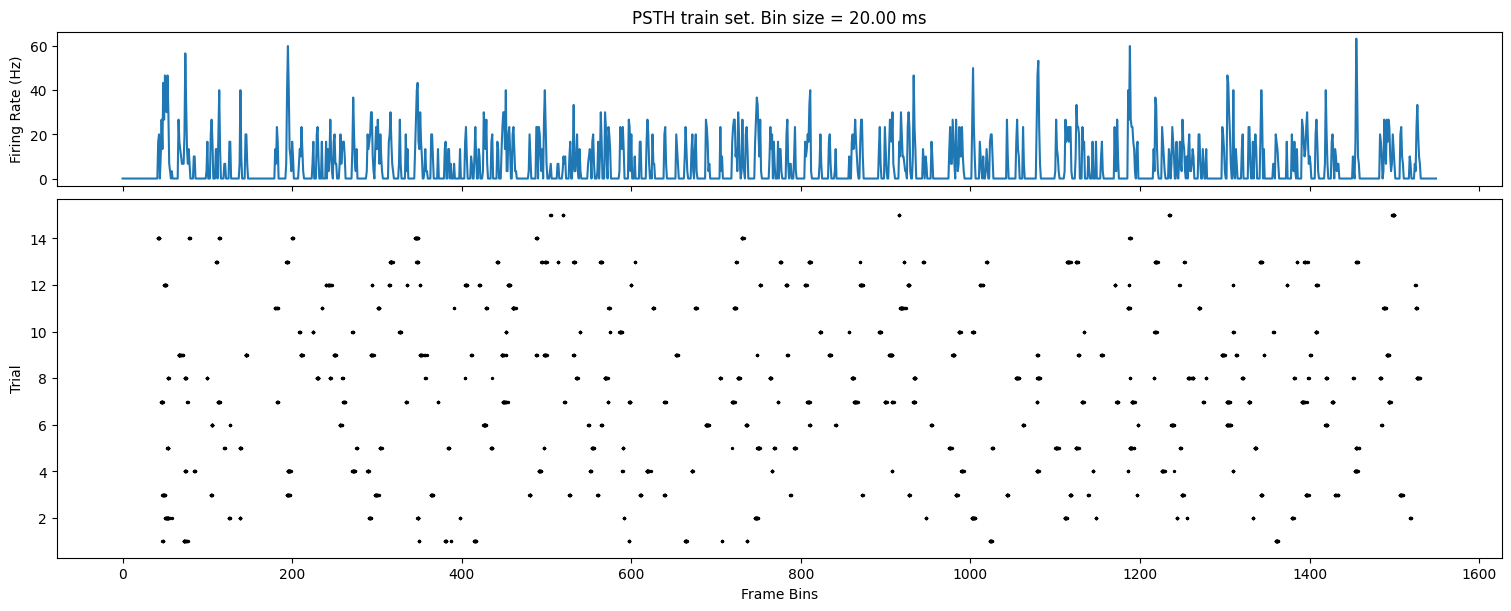

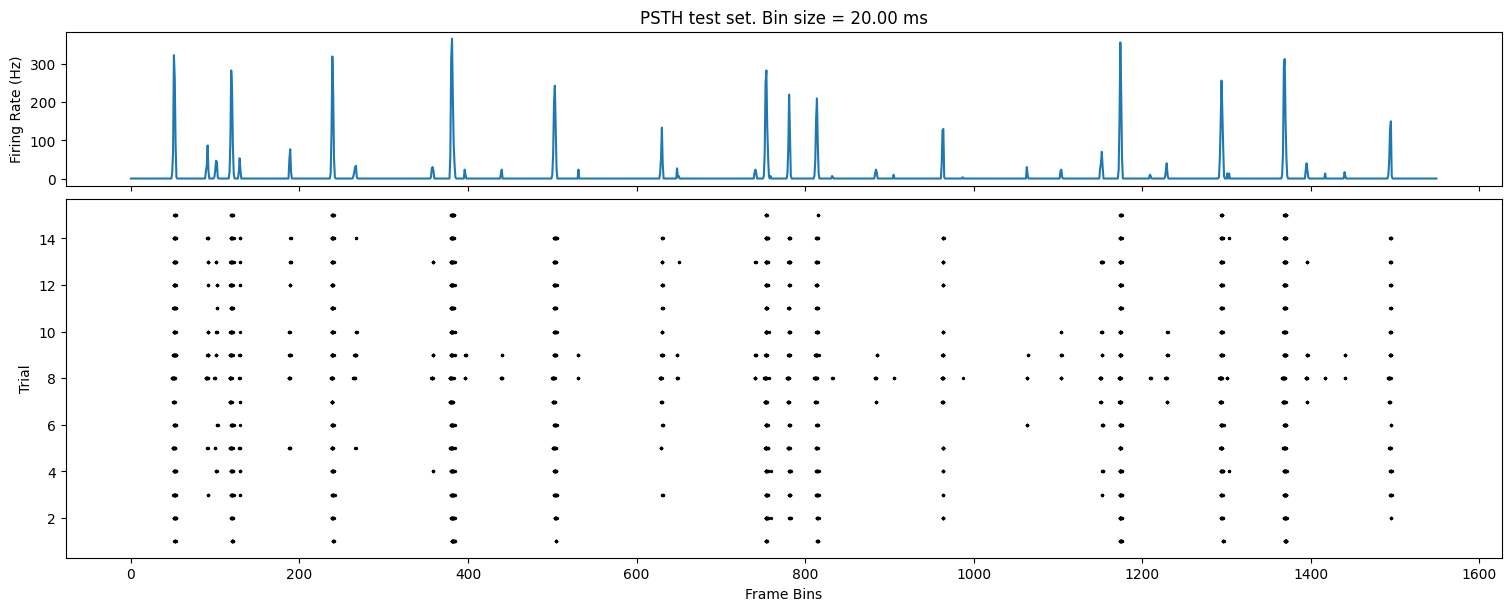

In [115]:
def plot_psth(binarized_spikes, title, bin_size, plotFlag=True):
    """
    Plot the PSTH and raster plot, accounting for multiple spikes per bin.
    
    Args:
        binarized_spikes (np.ndarray): Spike train array with shape (num_trials, num_bins), 
                                       where each entry represents the spike count in that bin.
        title (str): Title of the plot (usually 'train' or 'test').
        bin_size (float): Duration of each bin in seconds, used to calculate time intervals.
        plotFlag (bool): If True, displays the PSTH plot. Default is True.

    Returns:
        np.ndarray: PSTH array showing mean firing rate (Hz) per bin.
    """
    # Compute the PSTH as the firing rate per bin (Hz)
    psth = np.mean(binarized_spikes, axis=0) / bin_size  # Mean spike count per bin / bin duration for rate
    bin_size_ms = bin_size * 1000  # Convert bin size to milliseconds for display

    if plotFlag:
        fig, axs = plt.subplots(nrows=2, figsize=(15, 6), layout="constrained", sharex=True, height_ratios=[3, 7])

        # Plot the PSTH (Firing Rate)
        axs[0].plot(range(len(psth)), psth)
        axs[0].set_ylabel("Firing Rate (Hz)")
        axs[0].set_title(f"PSTH {title} set. Bin size = {bin_size_ms:.2f} ms")

        # Raster plot (show multiple spikes per bin by repeating the frame index)
        for i in range(binarized_spikes.shape[0]):
            spike_counts = binarized_spikes[i]  # Spike counts for each bin in this trial
            for bin_idx, count in enumerate(spike_counts):
                if count > 0:
                    axs[1].scatter(
                        np.repeat(bin_idx, count),  # Repeat the bin index for each spike
                        np.full(count, i + 1),      # Trial number repeated for each spike
                        color="black", s=2          # Smaller dots for clarity
                    )

        axs[1].set_xlabel("Frame Bins")
        axs[1].set_ylabel("Trial")
        # plt.xlim([25,50])
        plt.show()

    return psth

train_psth = plot_psth(train_binarized_spikes, 'train', bin_size=desired_bin_size)
test_psth = plot_psth(test_binarized_spikes, 'test', bin_size=desired_bin_size)




In [116]:
train_binarized_spikes

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

## Now we are ready for the LN model

The STA is the L part. We need to normalize so that the std of the convolution has values in the same range independent of the cell?

In [117]:
sta /= sta.std() #Normalizing the sta

In [118]:
def STA(df, window_size_ms, plotFlag = True):
    sta_window_samples = None  # Based on sampling rate
    sta_accumulator = None
    total_spikes = 0

    for _, trial in df.iterrows():
        stimulus = np.array(trial['stimulus'])  
        spike_indices = np.array(trial['spike_indices']).flatten() #units are samples (on amplifier)
        # samples / (samples/sec) * (frames/sec) = frames ~ frame during which spike occurred

        scale_factor = trial['frame_rate']/ trial['sample_rate'] 
        scaled_spike_indices = (spike_indices * scale_factor).astype(int) # frame index of spike

        if sta_window_samples is None: #number of frame samples in window
            sta_window_samples = int((window_size_ms / 1000) * trial['frame_rate']) 

        valid_spike_indices = scaled_spike_indices[scaled_spike_indices < len(stimulus)]

        for spike_idx in valid_spike_indices:
            if spike_idx >= sta_window_samples:  
                window = stimulus[spike_idx - sta_window_samples:spike_idx]
                if sta_accumulator is None:
                    sta_accumulator = np.zeros_like(window)  
                sta_accumulator += window
                total_spikes += 1

    print('Total spikes:', total_spikes)

    if total_spikes > 0 and sta_accumulator is not None:
        sta = sta_accumulator / total_spikes
        print('STA shape:', sta.shape)
        if plotFlag:
            time_axis = np.linspace(-window_size_ms, 0, sta_window_samples)
            plt.figure(figsize=(8, 4))
            plt.plot(time_axis, sta,'w')
            plt.xlabel('Time before spike (ms)')
            plt.ylabel('Average Stimulus')
            plt.title(f'Temporal STA with effective frame rate = {trial["frame_rate"]/trial["frame_dwell"]} Hz')
            plt.show()
    else:
        print("STA accumulator is empty or no valid spikes processed.")

    return sta, sta_window_samples #To return STA as a filter

In [119]:
for i in range(train_binarized_spikes.shape[0]):
    print(train_binarized_spikes[i].max())

7
8
8
9
8
9
8
9
8
8
9
8
9
8
6


In [120]:
train_binarized_spikes.shape

(15, 1550)

In [122]:
window_duration_ms = 650
window_duration = window_duration_ms / 1000
stim_bin_size= 1/30
spike_bin_size = desired_bin_size
num_sta_bins = int(window_duration / stim_bin_size)
if spike_bin_size > stim_bin_size:
    print("Spike bin size is greater than stimulus bin size. Downsampling stimulus...")
    factor = int(spike_bin_size /stim_bin_size)
    train_stim = train_stim[:len(train_stim) - len(train_stim) % factor]  # Truncate to fit factor
    train_stim = train_stim.reshape(-1, factor).mean(axis=1)
    stim_bin_size = spike_bin_size
elif spike_bin_size < stim_bin_size:
    print("Spike bin size is less than stimulus bin size. Upsampling stimulus...")
    factor = int(stim_bin_size / spike_bin_size)
    train_stim = np.repeat(train_stim, factor, axis=0)
    stim_bin_size = spike_bin_size

# Recalculate number of STA bins after resampling
num_sta_bins = int(window_duration / stim_bin_size)

# Initialize STA accumulator and spike counter
sta = np.zeros(num_sta_bins)
total_spikes = 0

# Debug print to confirm shapes after resampling
print("STA shape:", sta.shape)
print("Stimulus shape:", train_stim.shape)

# Loop over trials in binarized spike train
for trial in range(train_binarized_spikes.shape[0]):
    spike_counts = train_binarized_spikes[trial]  # Get spike count per bin
    spike_indices = np.where(spike_counts > 0)[0]  # Indices of bins with spikes

    for spike_index in spike_indices:
        # Get the actual spike count in this bin
        spike_count = spike_counts[spike_index]
        print(spike_count)
        # Ensure spike time has enough preceding data for the STA window
        if spike_index >= num_sta_bins:
            # Accumulate stimulus window, scaled by the spike count
            sta += spike_count * train_stim[spike_index - num_sta_bins:spike_index][::-1]
            total_spikes += spike_count  # Increment total spikes by the count in the bin

# Normalize the STA by the total spike count if non-zero
if total_spikes > 0:
    sta /= total_spikes
else:
    print("Warning: No spikes counted in the defined STA window duration.")

# Plot the STA
time_axis = np.linspace(-window_duration_ms, 0, num_sta_bins)  # Time axis in ms
plt.plot(time_axis, sta)
plt.xlabel("Time before spike (ms)")
plt.ylabel("Average Stimulus")
plt.title("Spike-Triggered Average (STA)")
plt.show()

Spike bin size is less than stimulus bin size. Upsampling stimulus...
STA shape: (32,)
Stimulus shape: (15, 1860)
1


ValueError: operands could not be broadcast together with shapes (32,) (0,1860) (32,) 

1.0


Text(0.5, 1.0, 'Normalized Stimulus Filter. Std = 1 ')

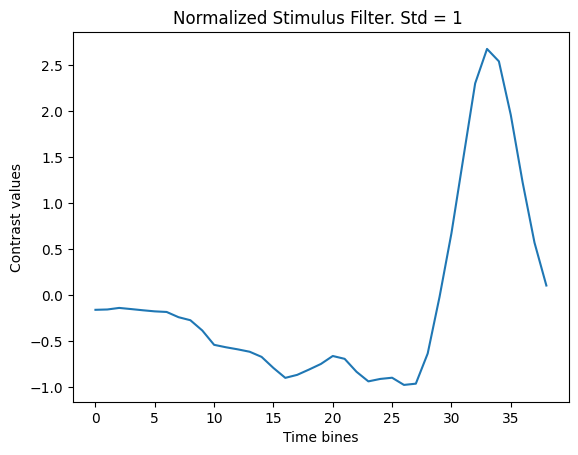

In [257]:
print(sta.std())
plt.plot(sta)
plt.xlabel('Time bines')
plt.ylabel('Contrast values')
plt.title(f'Normalized Stimulus Filter. Std = {round(sta.std())} ')

In [233]:
stim_x = np.load('training_stimulus_TG.npy')
spikes_x = np.load('training_spikes_TG.npy')
sta_x = np.load('training_sta_TG.npy')
print("stim shape",stim_x.shape)
print("spikes shape",spikes_x.shape)
print("sta shape",sta_x.shape)


stim shape (41, 1800)
spikes shape (41, 1800)
sta shape (45,)


sta shape (45,)


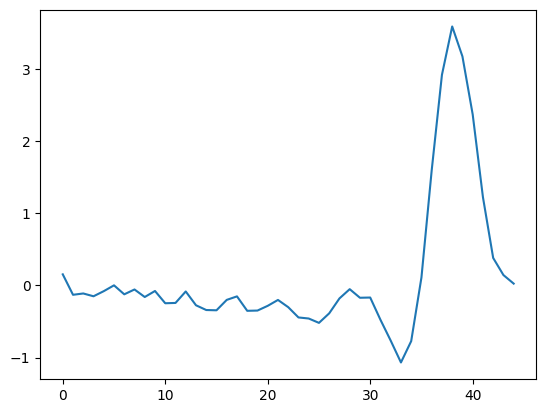

In [227]:
# sta_x = np.flip(sta_x)
print("sta shape",sta_x.shape)
plt.plot(sta_x)

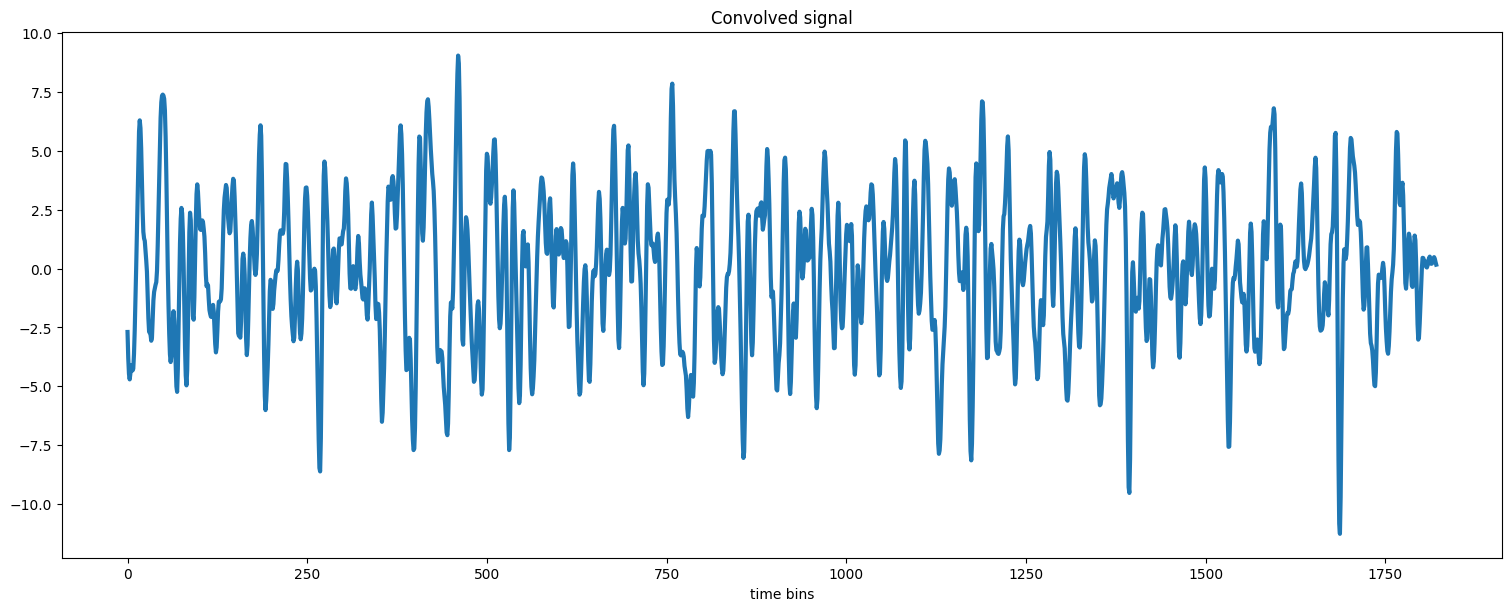

In [272]:
def convolve_stimulus_with_sta(stimulus_array, cell_sta, plotFlag=True):
    """
    Use np.convolve to compute the trial-by-trial convolution
    of the visual stimulus with a cell's spike-triggered avg.
    """
    conv_list = []
    
    for trial in stimulus_array:
        conv = np.convolve(trial, cell_sta[::-1], mode="valid") 
        conv_list.append(conv)
    
    if plotFlag:
        fig, ax = plt.subplots(figsize=(15, 6), layout="constrained")
        
        ax.plot(np.array(conv_list)[0], lw=3) #train stim
        ax.set_xlabel("time bins")
        ax.set_title("Convolved signal")
        plt.show()
        
    return np.array(conv_list)
convolved_signal = convolve_stimulus_with_sta(train_stim, sta)
# convolved_signal = convolved_signal[0] #For the test stimulus. 



In [260]:
num_past_pulses = train_binarized_spikes.shape[1] - convolved_signal.shape[1]
num_past_pulses

38

c:\Users\SchwartzLab\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\SchwartzLab\anaconda3\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Text(0, 0.5, 'Spike probability')

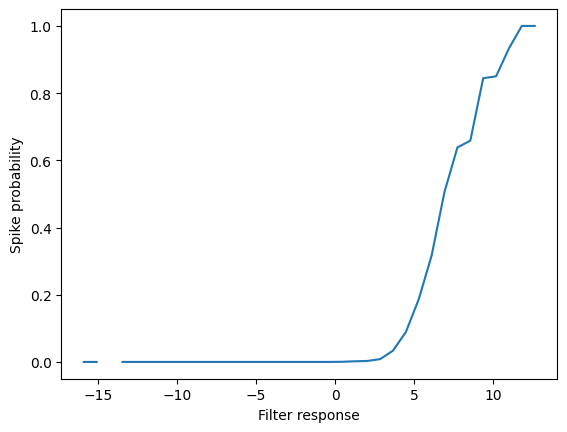

In [271]:
x= train_binarized_spikes[:, num_past_pulses:].ravel()
nbins = 50
i = np.digitize(convolved_signal.ravel(), np.linspace(-20,20,nbins))
p = [np.nanmean(x[i == j]) for j in range(nbins)]

plt.plot(np.linspace(-20,20,nbins), p)

plt.xlabel('Filter response')
plt.ylabel('Spike probability')

In [281]:
def exponential(x, a, b, c):
    """
    A parametrized exponential.
    """
    return a * np.exp(b * x + c)

optimal_parameters, _ = curve_fit(
    f=exponential,  # the function we'd like to fit
    xdata=convolved_signal.ravel(),  # x axis values
    ydata=train_binarized_spikes[:, num_past_pulses:].ravel(),  # y axis values
    p0=[2.0, 0.5, -3.0],  # initial parameters
    bounds=([0, -np.inf, -np.inf], np.inf),  # bounds
    maxfev=4000,  # just making sure the algorithm converges
)



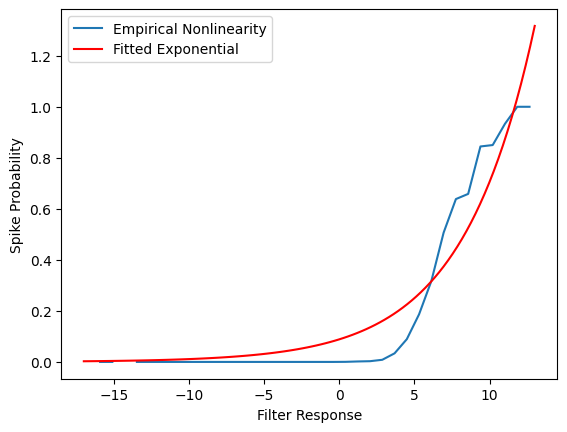

In [276]:
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt

# Clean up the 'p' array by filtering out NaN values
filter_response = np.linspace(-20, 20, nbins)
p = [np.nanmean(x[i == j]) for j in range(nbins)]
p = np.array(p)  # Convert to numpy array for easy indexing

# Filter out NaN values from both 'p' and 'filter_response'
valid_indices = ~np.isnan(p)  # True for non-NaN values
filtered_response = filter_response[valid_indices]
filtered_p = p[valid_indices]

# Define the exponential function
def exponential(x, a, b):
    return a * np.exp(b * x)

# Fit the exponential function to the filtered data
optimal_parameters, _ = curve_fit(exponential, filtered_response, filtered_p, p0=[1, 0.1])

# Generate smooth x values and calculate fitted y values for plotting
x_values = np.linspace(np.floor(convolved_signal.min()), np.ceil(convolved_signal.max()), 100)
y_fit = exponential(x_values, *optimal_parameters)

# Plot the empirical nonlinearity and fitted function
plt.plot(filter_response, p, label='Empirical Nonlinearity')
plt.plot(x_values, y_fit, label='Fitted Exponential', color='red')
plt.xlabel('Filter Response')
plt.ylabel('Spike Probability')
plt.legend()
plt.show()



In [277]:
x_values = np.linspace(
    start=np.floor(convolved_signal.min()),
    stop=np.ceil(convolved_signal.max()),
    num=31
)
y_fit = exponential(x_values, *optimal_parameters)

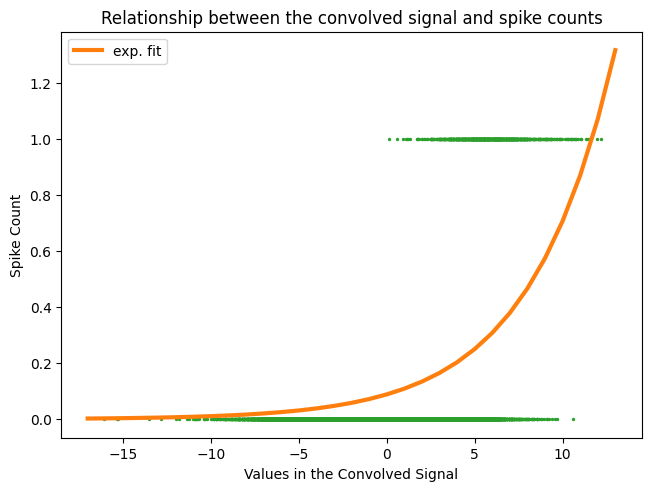

In [278]:
fig, ax = plt.subplots(layout="constrained")
ax.scatter(convolved_signal.ravel(), train_binarized_spikes[:, num_past_pulses:].ravel(), c="tab:green", s=2)
ax.plot(x_values, y_fit, lw=3, c="tab:orange", label="exp. fit")
ax.set_xlabel("Values in the Convolved Signal")
ax.set_ylabel("Spike Count")
ax.set_title("Relationship between the convolved signal and spike counts")
plt.legend()
plt.show()

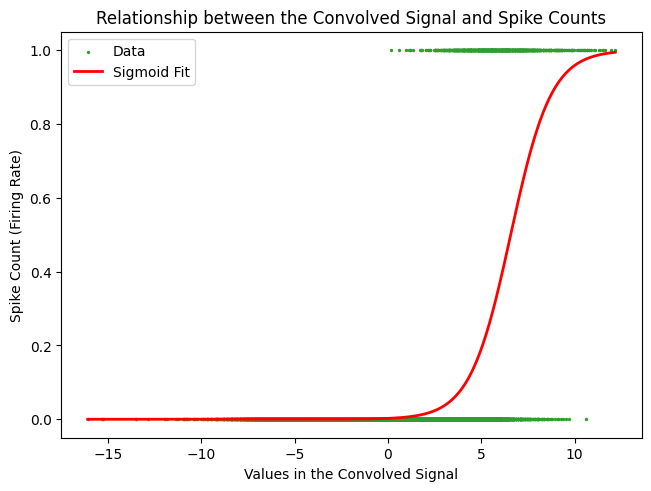

In [266]:
# Sigmoid function for fitting
def sigmoid(x, a, b):
    return 1 / (1 + np.exp(-(a * x + b)))

# Reshape and flatten data for fitting
x_data = convolved_signal.ravel()
y_data = train_binarized_spikes[:, num_past_pulses:].ravel()

# Fit the sigmoid nonlinearity
params, _ = curve_fit(sigmoid, x_data, y_data, p0=[4, 0], maxfev=4000)

# Generate values for the sigmoid curve
x_fit = np.linspace(min(x_data), max(x_data), 500)
y_fit = sigmoid(x_fit, *params)

# Plotting
fig, ax = plt.subplots(layout="constrained")

# Scatter plot of the data
ax.scatter(x_data, y_data, c="tab:green", s=2, label="Data")

# Sigmoid fit line
ax.plot(x_fit, y_fit, color="red", lw=2, label="Sigmoid Fit")

# Labels and title
ax.set_xlabel("Values in the Convolved Signal")
ax.set_ylabel("Spike Count (Firing Rate)")
ax.set_title("Relationship between the Convolved Signal and Spike Counts")
ax.legend()

plt.show()


In [279]:
test_convolved = convolve_stimulus_with_sta(test_stim[:1, :], sta, plotFlag=False)[0]
y_predicted = exponential(test_convolved, *optimal_parameters)

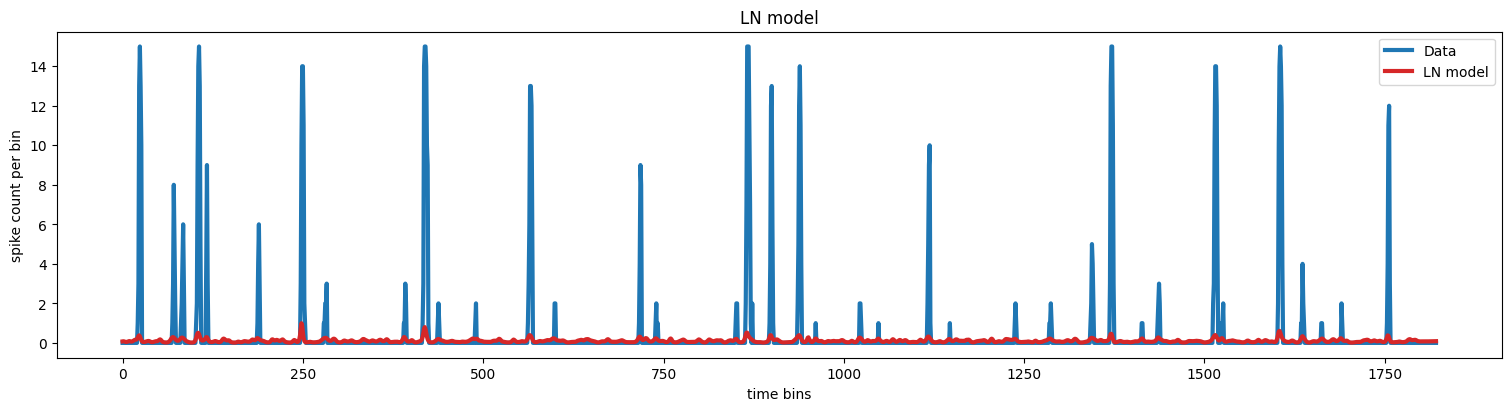

In [280]:
fig, ax = plt.subplots(figsize=(15, 4), layout="constrained")
ax.plot(test_psth[num_past_pulses:], lw=3, c="tab:blue", label="Data")
ax.plot(y_predicted, lw=3, c="tab:red", label="LN model")
ax.set_xlabel("time bins")
ax.set_ylabel("spike count per bin")
ax.set_title("LN model")
plt.legend()
plt.show()